# Lab 7-1: Snowpack ripening and melt initiation - Observations

Written by Eli Schwat February 2025.

In this lab, we will look at some measurements of snowpack temperature as well as precipitation, snowdepth, and soil moisture, to identify the ripening process and the initiation of melt at Kettle Ponds in mid-April 2023.

In [1]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import altair as alt

### SOS Data

In [2]:
# tower measurements
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

#precip measurements
precip_file = "../data/kettle_ponds_precip.csv"
precip_dataset = pd.read_csv(precip_file)
precip_dataset['date'] = pd.to_datetime(precip_dataset['date'])
precip_dataset = precip_dataset.set_index('date').to_xarray()

<Axes: xlabel='time'>

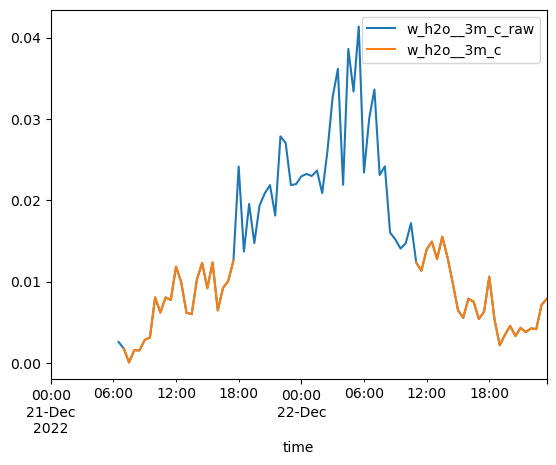

In [11]:
sos_dataset[['w_h2o__3m_c_raw', 'w_h2o__3m_c']].to_dataframe().loc['20221221': '20221222'].plot()

In [4]:
tsnow_vars = [v for v in sos_dataset if 'Tsnow_' in v and v.endswith('_d')]
snow_depth_vars = ['SnowDepth_d']
print(snow_depth_vars, tsnow_vars)

['SnowDepth_d'] ['Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d']


### Extract snow temperature data for vertical profiles (repeated from Lab4-1)

In [5]:
# Transform the NetCDF dataset to be a "tidy" dataset of snow depths
snow_temp_dataset = sos_dataset[
    tsnow_vars + snow_depth_vars
].to_dataframe().reset_index().set_index(['time', 'SnowDepth_d']).melt(ignore_index=False)

# Calculate the depth of the snow sensor (relative to the snow surface)
# using the snow depth measurements and the known above-ground height
# of the snow sensors, which is built into the variable name
snow_temp_dataset['height_agl'] = snow_temp_dataset['variable'].str[6:9].str.replace('_', '.').astype(float)
snow_temp_dataset = snow_temp_dataset.reset_index().set_index('time')
snow_temp_dataset['depth'] = snow_temp_dataset['height_agl'] - snow_temp_dataset['SnowDepth_d']

# remove measurements NOT in the snowpack
snow_temp_dataset = snow_temp_dataset.query("depth < 0")

# Add surface temperature data (depth=0)
surface_temps_dataset = sos_dataset['Tsurf_d'].to_dataframe()
surface_temps_dataset = surface_temps_dataset.rename(columns={'Tsurf_d': 'value'})
surface_temps_dataset['depth'] = 0

# Combine snow surface and in-snow temperature data
snow_temp_dataset = pd.concat([snow_temp_dataset, surface_temps_dataset])

## Plot snow temperature profiles during ripening process

In [6]:
src = snow_temp_dataset.sort_index().loc['20230407': '20230412'].reset_index()

alt.Chart(
    src.assign(hour = src.time.dt.hour)[src.time.dt.minute == 0][src.time.dt.hour % 3 == 2]
).mark_line().encode(
    alt.X('value:Q').title('T (˚C)'),
    alt.Y('depth:Q'),
    alt.Color('hour:O').scale(scheme='rainbow'),
    alt.Facet('date(time):O', columns=6),
    order='depth'
).properties(width=150, height = 150)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_76557/4033044778.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src.assign(hour = src.time.dt.hour)[src.time.dt.minute == 0][src.time.dt.hour % 3 == 2]


alt.Chart(...)

We can see the ripening process occur between April 8 and 10, with snowpack temperatures reaching 0˚C throughout the profile, except near the surface. Note that this is common - outgoing longwave radiation causes cooling at the very surface of the snowpack, even though the snowpack beneath is ripe.

Notice that the snowpack is getting  shallower throughout this process. There was no precip on these days. Was there snow melt happening? We can estimate when snowmelt started by looking at the soil moisture measurements. A soil moisture sensor was buried 2.5cm deep in the soil. Let's also look at snow surface temperatures - 0˚C temperatures could indicate melting at the surface.

In [9]:
snowdepth_chart = alt.Chart(
    sos_dataset['SnowDepth_d'].to_dataframe().loc['20230401': '20230412'].reset_index()
).mark_line(color='purple').encode(
    alt.X('time:T').axis(format=" ").title(None),
    alt.Y('SnowDepth_d:Q').title('Snow depth (m)').axis(labelColor='purple', titleColor='purple')
).properties(height = 100)

precip_chart = alt.Chart( 
    precip_dataset.to_dataframe().loc['20230401': '20230412'].reset_index()
).mark_line(color='orange').encode(
    alt.X('date:T').title('time'),
    alt.Y('acc_prec:Q').title(['Cumulative', 'precip (mm)']).axis(labelColor='orange', titleColor='orange')
).properties(height = 100)

soilmoisture_chart = alt.Chart(
    sos_dataset['Qsoil_d'].to_dataframe().loc['20230401': '20230412'].reset_index()
).mark_line(color='black').encode(
    alt.X('time:T').axis(format=" ").title(None),
    alt.Y('Qsoil_d:Q').title(['Soil moisture', 'at 2.5cm (m^3/m^3)'])
).properties(height = 100)

surface_temp_chart = alt.Chart(
    sos_dataset[['Tsurf_c', 'Tsurf_ue', 'Tsurf_uw', 'Tsurf_d']].to_dataframe().loc['20230401': '20230412'].reset_index()
).transform_fold(
    ['Tsurf_c', 'Tsurf_ue', 'Tsurf_uw', 'Tsurf_d']
).mark_line(color='black').encode(
    alt.X('time:T'),
    alt.Y('value:Q').title("Surface temp (˚C)"),
    alt.Color('key:N')
).properties(height = 100)

(
    (snowdepth_chart + precip_chart).resolve_scale(y='independent')
    &
    soilmoisture_chart
    &
    surface_temp_chart
)



alt.VConcatChart(...)

It looks like melt reached the bottom of the snowpack in the afternoon of April 9, just slightly ahead of when the temperature sensors indicate the snowpack ripened! This makes sense as melt at the snowpack surface should occur before water leaches to the bottom of the snowpack.